In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [2]:
# Image completion
import os
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

dog.jpg exists


In [3]:
# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


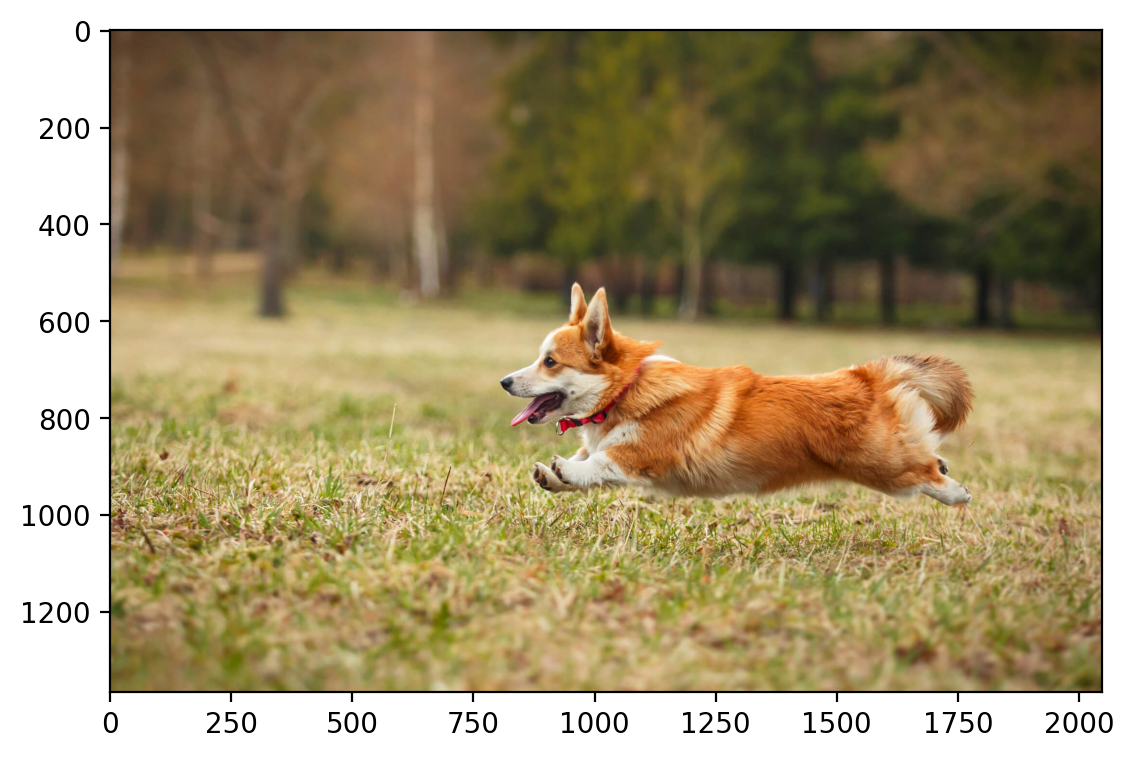

In [4]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

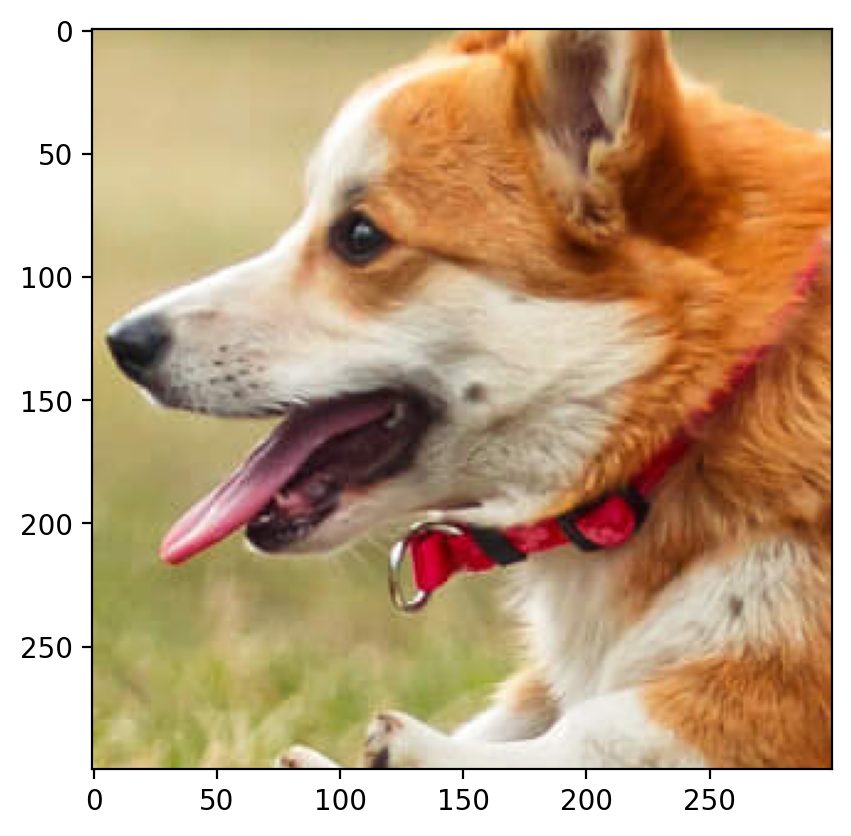

In [5]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img
from sklearn.preprocessing import MinMaxScaler
MinMaxScaler()
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)
img_scaled
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 300, 300)
crop.shape
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [6]:
original_image = crop.clone()

In [7]:
def create_missing_patch_with_nan(img, start_h, start_w, patch_size):
    img_copy = img.clone()

    # Check if the image is grayscale or color
    if len(img_copy.shape) == 2:  # Grayscale image
        img_copy[start_h:start_h+patch_size, start_w:start_w+patch_size] = float('nan')
    elif len(img_copy.shape) == 3:  # Color image
        img_copy[:, start_h:start_h+patch_size, start_w:start_w+patch_size] = float('nan')

    return img_copy

In [8]:
# # Assuming 'img' is your original image
# start_h = 100
# start_w = 100
# patch_size = 30

# # Create an image with a missing patch filled with NaN values
# img_with_missing_patch = create_missing_patch_with_nan(crop, start_h, start_w, patch_size)

In [9]:
# plt.imshow(rearrange(img_with_missing_patch, 'c h w -> h w c').cpu().numpy())

In [10]:
# def factorize(A, k, device=torch.device("cpu")):
#     """Factorize the matrix D into A and B"""
#     A = A.to(device)

#     # Randomly initialize A and B for each channel
#     W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
#     H = torch.randn(k, A.shape[1], requires_grad=True, device=device)

#     # Optimizer
#     optimizer = optim.Adam([W, H], lr=0.01)

#     mask = ~torch.isnan(A)

#     for i in range(1000):
#         # Compute the loss
#         diff_matrix = torch.mm(W, H) - A
#         diff_vector = diff_matrix[mask]
#         loss = torch.norm(diff_vector)
        
#         # Zero the gradients
#         optimizer.zero_grad()
        
#         # Backpropagate
#         loss.backward()
        
#         # Update the parameters
#         optimizer.step()
        
#     return W, H, loss


In [32]:
import torch
from torch import optim

def factorize(A, k, device=torch.device("cpu")):
    """Factorize the matrix D into A and B using Alternating Least Squares (ALS)"""
    A = A.to(device)

    # Randomly initialize A and B for each channel with the same dtype as A
    dtype = A.dtype
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device, dtype=dtype)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device, dtype=dtype)
    mask = ~torch.isnan(A)
    #A[mask==False]=np.random.unifor(0,1)
    for i in range(1000):    
        for j in range(H.shape[1]):
                mask_rows= ~torch.isnan(A[:,j])
                # h_j = torch.linalg.lstsq(W[mask_rows], A[:, j][mask_rows].to(dtype).unsqueeze(1))[0].squeeze()
                h_j = torch.linalg.lstsq(W[mask_rows], A[:, j][mask_rows]).solution
                with torch.no_grad():
                    H[:, j] = h_j
                    
        A_=A.t()
        W_=W.t()
        H_=H.t()
        for j in range(W_.shape[1]):
                mask_rows= ~torch.isnan(A_[:,j])
                w_j = torch.linalg.lstsq(H_[mask_rows], A_[:, j][mask_rows]).solution
                with torch.no_grad():
                    W_[:,j] = w_j
        
        W=W_.t()
        if i%100==0:
            print(f"epoch {i}")
    # Compute the final loss
    diff_matrix = torch.mm(W, H) - A
    #diff_vector = diff_matrix[mask]
    loss = torch.norm(diff_matrix)
    return W, H, loss


In [33]:
Errors={'Type':[],'RMSE': [],'Peak SNR':[]}

In [34]:
def plot_reconstructed_and_original_image(original_img, img_with_missing_patch, finalImg, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1,1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax2 = plt.subplot(gs[2])

    ax0.imshow(rearrange(original_img, 'c h w -> h w c').cpu().detach().numpy())
    #ax0.imshow(original_image.reshape(300,300,3).cpu().numpy())
    ax0.set_title("Original Image")


    ax1.imshow(rearrange(img_with_missing_patch, 'c h w -> h w c').cpu().detach().numpy())
    #ax1.imshow(img_with_missing_patch.reshape(300,300,3).cpu().numpy())
    ax1.set_title("Image with missing patch")
    #ax2.imshow(finalImg.reshape(300,300,3).cpu().numpy())
    ax2.imshow(rearrange(finalImg, 'c h w -> h w c').cpu().detach().numpy())
    ax2.set_title(f"Reconstructed Image")
    squared_error = torch.square(rearrange(finalImg, 'c h w -> h w c').cpu() - rearrange(original_img, 'c h w -> h w c').cpu())
    mse = torch.mean(squared_error)

    # Calculate the root mean squared error
    rmse = torch.sqrt(mse)

    # Calculate the peak signal value (assuming the vectors are in the range [0, 1])
    max_val = 1.0
    psnr = 10 * torch.log10(max_val / rmse)
    Errors["Type"].append(title)
    Errors["RMSE"].append(rmse.cpu().detach().numpy())
    Errors["Peak SNR"].append(psnr.cpu().detach().numpy())
    print(f"Type: {title} , RMSE: {rmse}, PSNR: {psnr} \n")

# Calculate the PSNR
    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

epoch 0
epoch 100
epoch 200
epoch 300
epoch 400
epoch 500
epoch 600
epoch 700
epoch 800
epoch 900
epoch 0
epoch 100
epoch 200
epoch 300
epoch 400
epoch 500
epoch 600
epoch 700
epoch 800
epoch 900
epoch 0
epoch 100
epoch 200
epoch 300
epoch 400
epoch 500
epoch 600
epoch 700
epoch 800
epoch 900


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Type: Reconstructed Image for Single Color , RMSE: 0.18181171788680126, PSNR: 7.403781296422215 

ErrorDF:                                     Type                 RMSE  \
0  Reconstructed Image for Single Color  0.18181171788680126   

            Peak SNR  
0  7.403781296422215  


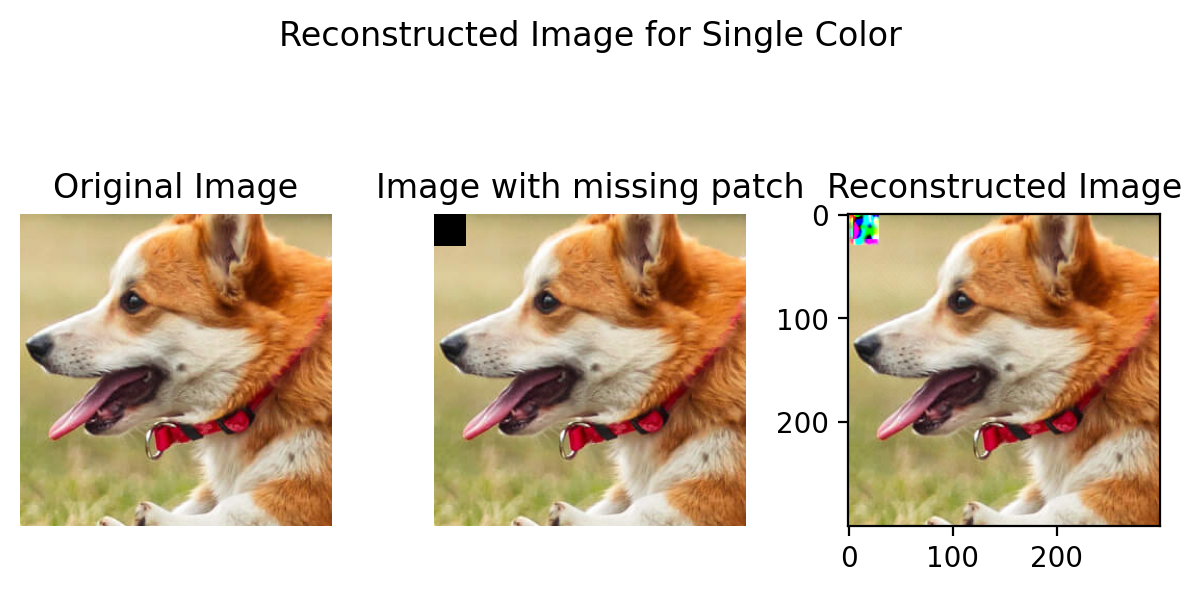

In [35]:
start_x = [0]
start_y = [0]
label=["Single Color","2-3 Color","At least 5 color"]
patch_size=30
for idx,i in enumerate(start_x):
    img_with_missing_patch = create_missing_patch_with_nan(crop, i, start_y[idx], patch_size)
    Wr, Hr, lossr = factorize(img_with_missing_patch[0], 100, device=device)
    Wg, Hg, lossr = factorize(img_with_missing_patch[1], 100, device=device)
    wb, Hb, lossr = factorize(img_with_missing_patch[2], 100, device=device)
    finalImg=torch.Tensor(3,300,300)
    finalImg[0]=torch.mm(Wr,Hr)
    finalImg[1]=torch.mm(Wg,Hg)
    finalImg[2]=torch.mm(wb,Hb)
    plot_reconstructed_and_original_image(crop,img_with_missing_patch,finalImg,title=f"Reconstructed Image for {label[idx]}")

ErrorDF=pd.DataFrame(Errors)
ErrorDF.reset_index(drop=True, inplace=True)

print("ErrorDF: ",ErrorDF)

    
    

    

In [ ]:
# class LinearModel(nn.Module):
#     def __init__(self, in_features, out_features):
#         super(LinearModel, self).__init__()
#         self.linear = nn.Linear(in_features, out_features)

#     def forward(self, x):
#         return self.linear(x)

In [ ]:
# # create RFF features
# def create_rff_features(X, num_features, sigma):
#     from sklearn.kernel_approximation import RBFSampler
#     rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
#     X = X.cpu().numpy()
#     X = rff.fit_transform(X)
#     return torch.tensor(X, dtype=torch.float32).to(device)

In [ ]:
# def train(net, lr, X, Y, epochs, batch_size=32, verbose=True):
#     """
#     net: torch.nn.Module
#     lr: float
#     X: torch.Tensor of shape (num_samples, 2)
#     Y: torch.Tensor of shape (num_samples, 3)
#     epochs: int
#     batch_size: int, default=32
#     verbose: bool, default=True
#     """

#     criterion = nn.MSELoss()
#     optimizer = torch.optim.Adam(net.parameters(), lr=lr)

#     num_samples = X.shape[0]
#     num_batches = (num_samples + batch_size - 1) // batch_size

#     for epoch in range(epochs):
#         running_loss = 0.0
#         for i in range(num_batches):
#             optimizer.zero_grad()
#             start_idx = i * batch_size
#             end_idx = min((i + 1) * batch_size, num_samples)
#             batch_X = X[start_idx:end_idx]
#             batch_Y = Y[start_idx:end_idx]
#             outputs = net(batch_X)
#             loss = criterion(outputs, batch_Y)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item()

#         if verbose and epoch % 100 == 0:
#             print(f"Epoch {epoch} loss: {running_loss / num_batches:.6f}")


In [ ]:
# Errors_rff={'Type':[],'RMSE': [],'Peak SNR':[]}

In [ ]:
# def plot_reconstructed_and_original_image_RFF(original_img, net, X,maskedImage, title=""):
#     """
#     net: torch.nn.Module
#     X: torch.Tensor of shape (num_samples, 2)
#     Y: torch.Tensor of shape (num_samples, 3)
#     """
#     num_channels, height, width = original_img.shape
#     net.eval()
#     with torch.no_grad():
#         outputs = net(X)
#         outputs = outputs.reshape(300, 300, 3)
#         #outputs = outputs.permute(1, 2, 0)
#     fig = plt.figure(figsize=(6, 4))
#     gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1,1])

#     ax0 = plt.subplot(gs[0])
#     ax1 = plt.subplot(gs[1])
#     ax2 = plt.subplot(gs[2])

#     ax2.set_title(f"Reconstucted Image")
#     ax2.imshow(outputs.cpu())
#     ax0.set_title("Original Image")
#     ax0.imshow(original_img.cpu().permute(1, 2, 0))
#     ax1.set_title("Image with missing block")
#     ax1.imshow(maskedImage.reshape(300,300,3).cpu().numpy())
    

#     squared_error = torch.square(outputs.cpu() - original_img.cpu().permute(1,2,0))
#     mse = torch.mean(squared_error)


#     # Calculate the root mean squared error
#     rmse = torch.sqrt(mse)

#     # Calculate the peak signal value (assuming the vectors are in the range [0, 1])
#     max_val = 1.0
#     psnr = 10 * torch.log10(max_val / rmse)
#     Errors_rff["Type"].append(title)
#     Errors_rff["RMSE"].append(rmse.cpu().detach().numpy())
#     Errors_rff["Peak SNR"].append(psnr.cpu().detach().numpy())
#     print(f"Type: {title} , RMSE: {rmse}, PSNR: {psnr} \n")

# # Calculate the PSNR
#     for a in [ax0, ax1]:
#         a.axis("off")


#     fig.suptitle(title, y=0.9)
#     plt.tight_layout()

In [ ]:
# start_x=[100,100,190]
# start_y=[120,70,190]
# label=["Single Color","2-3 Color","At least 5 color"]
# patch_size=30
# crop_ = rearrange(crop, 'c h w -> (h w) c').float()
# crop_=torch.tensor(crop_,dtype=torch.float32).to(device)
# for idx,i in enumerate(start_x):
#     img_with_missing_patch = create_missing_patch_with_nan(crop, i, start_y[idx], patch_size)
#     maskedImage=rearrange(img_with_missing_patch,'c h w -> (h w) c').float()
#     mask = ~torch.isnan(maskedImage)
#     mmMask=mask.cpu().numpy().reshape(270000,1)
#     mmImage=maskedImage.cpu().numpy().reshape(270000,1)
#     mmImage[mmMask==False]=np.random.uniform(0,1)
#     mmImage=torch.tensor(mmImage.reshape(90000,3),dtype=torch.float32).to(device)
#     X_rff = create_rff_features(mmImage, 10000, 0.008)
#     net = LinearModel(X_rff.shape[1], 3)
#     net.to(device)
#     train(net, 0.005, X_rff,crop_, 1000,100,True)
#     plot_reconstructed_and_original_image_RFF(crop, net, X_rff,maskedImage, title=f"Reconstructed Image for {label[idx]}")
#     del X_rff


# ErrorDF_RFF=pd.DataFrame(Errors_rff)
# ErrorDF_RFF.reset_index(drop=True, inplace=True)

# print("ErrorDF_RFF: ",ErrorDF_RFF)
